# Crime Prediction using Tweets and KDE

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook


from utils.consts import START_DATE, END_DATE, KDE_BANDWITH, LDA_PARAMS, LDA_TOPICS

from utils.geo import latlng2grid_cords_chicago, \
                      latlng2LDA_topics_chicago, \
                      generate_chicago_threat_grid_list, \
                      enrich_with_chicago_grid_200, \
                      CHICAGO_UTM_COORDS, FALSE_LABLE_DATASET_CELL_SIZE

In [2]:
RAW_CRIMES_DATA_PATH = os.path.join('data', 'raw', 'Crimes_-_2001_to_present.csv')
PROCESSED_CRIMES_DATA_PATH = os.path.join('data', 'processed', 'crime_data.csv')

RAW_TWEETS_DATA_WILDCARD_PATH = ('"' +
                                 os.path.join('data', 'raw', 'tweets', '*.json') +
                                 '"')
PROCESSED_TWEETS_DATA_PATH = os.path.join('data', 'processed', 'tweets_data.csv')

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2017-12-08 ---> 2018-02-19


## Data Sources & Preprocessing

### Chicago Crimes Incidents

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

INFO:root:Loading raw crime data...
INFO:root:#: 6544862
INFO:root:Arranging columns...
INFO:root:Filtering by time...
INFO:root:#: 6544862
INFO:root:#: 45869
INFO:root:Filtering by location...
INFO:root:#: 45195
INFO:root:Filtering by crime type...
INFO:root:#: 10902
INFO:root:Selecting columns...
INFO:root:#: 10902
INFO:root:Sorting by time...
INFO:root:#: 10902
INFO:root:Saving processed crime data...
INFO:root:Done!


In [4]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)

In [5]:
len(crimes_data)

10902

In [6]:
crimes_data['timestamp'].agg(['min', 'max'])

min    2017-12-08 01:00:00
max    2018-02-19 12:50:00
Name: timestamp, dtype: object

### Tweets

In [8]:
%%time

if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

INFO:root:Processing tweets jsons...
100%|███████████████████████████████████████| 1072/1072 [19:48<00:00,  1.11s/it]
INFO:root:# raw tweets: 1135099
INFO:root:# final tweets: 79634
INFO:root:% final tweets: 7.0155995203942565
INFO:root:% with geo key: 10.790864937771948
INFO:root:% with no geo key but with place:
admin           31.747363
city            54.278437
country          1.595456
neighborhood     0.753855
poi              0.731478
dtype: float64
INFO:root:Saving processed tweets data...
INFO:root:Done!
CPU times: user 23.7 s, sys: 7.43 s, total: 31.1 s
Wall time: 19min 51s


In [12]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [8]:
len(tweets_data)

79634

In [11]:
tweets_data['timestamp'].agg(['min', 'max'])

min    2017-12-08 19:58:35
max    2018-02-19 01:27:36
Name: timestamp, dtype: object

#### Sub-grouping by Geo-Location

In [7]:
def generate_tweets_docs(tweets_data):
    tweet_docs_groupby = tweets_data.groupby(('latitude_index', 'longitude_index'))
    tweet_docs = tweet_docs_groupby['tokens'].apply(lambda r : list(r)).apply(lambda r: sum(r, []))
    tweet_docs = tweet_docs.sort_index()
    return tweet_docs

In [8]:
chicago_grid_mask = lambda lat, lng: latlng2grid_cords_chicago(lat, lng) in tweet_docs.index

## Feature Extracts

### KDE

In [9]:
from sklearn.neighbors.kde import KernelDensity

def train_KDE_model(train_df, bandwith=KDE_BANDWITH):
    '''
    Train KDE model.

    Input:
    train_df: train data frame with Latitude Logitude. 3 months prior data for the day of surveillance..

    Output:
    KDE Model
    '''
    
    kde = KernelDensity(bandwidth=bandwith,
                        metric='haversine',
                        kernel='gaussian',
                        algorithm='ball_tree')
    
    kde.fit(train_df[['latitude','longitude']])
    
    return kde

In [10]:
crimes_kde_model = train_KDE_model(crimes_data)

### TODO - visualization

### Sentiment Analysis

### LDA

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def coalesce(token):
    '''
    Klaues: why this function?
    '''
    new_tokens = []
    for char in token:
        if len(new_tokens) < 2 or char != new_tokens[-1] or char != new_tokens[-2]:
            new_tokens.append(char)
    return ''.join(new_tokens)

def preprocess_tweet_for_LDA(raw_tokens):
    '''
    text input is one string
    output is tokenized and preprocessed(as defined below) text
    
    lowercase
    no hashtags or mentions
    any url converted to "url"
    replace multiple repeated chars with 2 of them. eg paaaarty -> paarty
    '''
    
    processed_tokens = []
    for token in raw_tokens:
        if token.startswith("@") or token.startswith("#"):
            continue
        elif token.startswith("https://") or token.startswith("http://"):
            processed_tokens.append("url")
        else:
            processed_tokens.append(coalesce(token))
            
    return processed_tokens

def train_LDA_model(docs, params=LDA_PARAMS, preprocessor=preprocess_tweet_for_LDA):
    
    vectorizer = CountVectorizer(stop_words="english",
                                 preprocessor=preprocessor,
                                 tokenizer=lambda x:x)
    
    lda_train_data = vectorizer.fit_transform(docs)
    
    lda_model = LatentDirichletAllocation(n_components=params['n_components'],
                                          max_iter=params['max_iter'],
                                          learning_method=params['learning_method'],
                                          learning_offset=params['learning_offset'],
                                          random_state=params['random_state'],
                                          verbose=params['verbose'])

    lda_model.fit(lda_train_data)
    
    doc_topics = lda_model.transform(lda_train_data)
    
    vocabulary = vectorizer.get_feature_names()
    
    return lda_model, doc_topics, vocabulary

In [12]:
tweets_lda_model, doc_topics, tweets_vocabulary = train_LDA_model(tweet_docs.tolist())

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [13]:
def get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words):
    topic = lda_model.components_[topic_index]
    return [vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            
def print_top_words_LDA(lda_model, vocabulary, n_top_words):
    for topic_idx in range(len(lda_model.components_)):
        
        message = "Topic #%d: " % topic_index
        message += " | ".join(get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words))

        print(message)
    print()
    
# print_top_words_LDA(tweets_lda_model, tweets_vocabulary, 5)    


get_tweets_topic_top_words_LDA = functools.partial(get_topic_top_words_LDA,
                                                   lda_model=tweets_lda_model,
                                                   vocabulary=tweets_vocabulary,
                                                   n_top_words=5)

latlng2LDA_tweet_topics_chicago = functools.partial(latlng2LDA_topics_chicago,
                                                doc_topics=doc_topics,
                                                docs=tweet_docs)

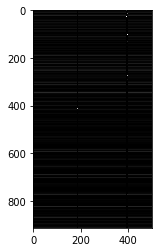

In [14]:
plt.imshow(doc_topics/doc_topics.max(axis=0), cmap='gray')

## Model Training & Evaluation

### Prepare datasets

In [15]:
import imp
import utils.consts
imp.reload(utils.consts)
import utils.geo
imp.reload(utils.geo)

<module 'utils.geo' from '/Users/shlomi/projects/Crime-Prediction-with-Tweets/pipeline/utils/geo.py'>

In [18]:
train_crime_stats = pd.concat({'#': train_dataset['crime'].value_counts()}, axis=1)
train_crime_stats['%'] = ((train_crime_stats['#'] / train_crime_stats['#'].sum()) * 100).round().astype(int)
train_crime_stats

,#,%
False,22858,74
True,8106,26


### Training

In [23]:
from sklearn.linear_model import LogisticRegression

2.8198865038243275

LogisticRegression(C=2.8198865038243275, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Evaluation

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [163]:
set(threat_by_KDE.index) == set(threat_by_logreg.index)

True

In [114]:
threat_by_KDE = predicted_threat_grid.set_index(['latitude_index', 'longitude_index'])['KDE'].sort_values(ascending=False)
threat_by_logreg = predicted_threat_grid.set_index(['latitude_index', 'longitude_index'])['threat'].sort_values(ascending=False)

In [124]:
crimes_indexes = utils.geo.enrich_with_chicago_grid_200(train_dataset[train_dataset['crime']])[['latitude_index', 'longitude_index']]

/Users/shlomi/projects/Crime-Prediction-with-Tweets/pipeline/utils/geo.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  .astype(int))
/Users/shlomi/projects/Crime-Prediction-with-Tweets/pipeline/utils/geo.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  .astype(int))


In [152]:
crime_counts = crimes_indexes.groupby(['latitude_index', 'longitude_index']).size()
crime_freqs = crime_counts / crime_counts.sum()

In [174]:
graph = np.zeros(len(threat_by_KDE))
for cell_index, threat_cell_indices in enumerate(threat_by_KDE.index):
    cell_crime_freq= crime_freqs.get(threat_cell_indices, 0)
    graph[cell_index] = cell_crime_freq

In [173]:
graph2 = np.zeros(len(threat_by_KDE))
for cell_index, threat_cell_indices in enumerate(threat_by_logreg.index):
    cell_crime_freq= crime_freqs.get(threat_cell_indices, 0)
    graph2[cell_index] = cell_crime_freq

In [172]:
graph3 = np.zeros(len(threat_by_KDE))
for cell_index, threat_cell_indices in enumerate(crime_counts.sort_values(ascending=False).index):
    cell_crime_freq= crime_freqs.get(threat_cell_indices, 0)
    graph3[cell_index] = cell_crime_freq

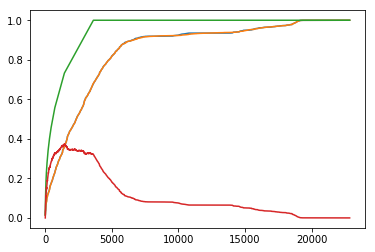

In [179]:
plt.figure()
plt.plot(graph.cumsum())
plt.plot(graph2.cumsum())
plt.plot(graph3.cumsum())
plt.plot(graph3.cumsum()-graph.cumsum())
plt.legend()

In [134]:
threat_by_KDE.index.get_loc(ind).start

/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py:283: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self.dispatch_shell(stream, msg)


6425

In [ ]:
def generate_one_step_train_dataset(crimes_dataset, tweets_dataset):
    crimes_kde_model = train_KDE_model(crimes_dataset)
    
    tweets_docs = generate_tweets_docs(tweets_dataset)
    tweets_lda_model, doc_topics, tweets_vocabulary = train_LDA_model(tweet_docs.tolist())
    
    train_dataset = pd.concat([crimes_data[['latitude', 'longitude']].assign(crime=True),
                            generate_chicago_threat_grid_list().assign(crime=False)],
                    axis=0)
    '''
    train_dataset['exists_tweets_data'] = train_dataset.apply(
        lambda r: chicago_grid_mask(r['latitude'], r['longitude']),
    axis=1)
    train_dataset = train_dataset[train_dataset['exists_tweets_data']]

    '''

    train_dataset = train_dataset[['latitude', 'longitude', 'crime']]
    train_dataset = enrich_with_chicago_grid_200(train_dataset)

    train_dataset['KDE'] = crimes_kde_model.score_samples(
        train_dataset[['latitude', 'longitude']].as_matrix()
    )

    train_dataset[LDA_TOPICS] = train_dataset.apply(lambda row: pd.Series(latlng2LDA_tweet_topics_chicago(
                                                                    row['latitude'],
                                                                    row['longitude'])),
                                        axis=1)

    features_cols = ['KDE'] + LDA_TOPICS

    train_dataset['crime'] = {
                        'X': train_dataset[['latitude_index', 'longtitude_index'] + features_cols],
                        'Y': train_dataset['crime']
    }
    
    return train_dataset



def generate_one_step_evaluation_dataset(crimes_evaluation_dataset):
    evaluation_dataset = enrich_with_chicago_grid_200(crimes_evaluation_dataset)
    evaluation_dataset = evaluation_dataset[['latitude_index', 'longitude_index']]
    return evaluation_dataset

def generate_one_step_datasets(crimes_data, tweets_data, start_train_date, n_train_days):
    start_train_date = pd.to_datetime(start_train_date)
    end_train_date = start_train_date + + pd.DateOffset(n_train_days)
    evaluation_date = end_train_date + pd.DateOffset(1)
    
    crimes_train_dataset = crimes_data[(crimes_data['timestamps'] >= start_train_date) &
                                       ((crimes_data['timestamps'] <= end_train_date))]
    
    tweets_train_dataset = tweets_data[(tweets_data['timestamps'] >= start_train_date) &
                                       ((tweets_data['timestamps'] <= end_train_date))]
    
    crimes_evaluation_dataset = crimes_data[crimes_data['timestamps'] == evaluation_date]
    
    train_dataset = generate_one_step_train_dataset(crimes_train_dataset, tweets_train_dataset)
    evaluation_dataset = generate_one_step_evaluation_dataset(crimes_evaluation_dataset):
    
    return train_dataset, evaluation_dataset


In [ ]:
def generate_threat_kde_dataset(train_dataset):
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']['crime']]
    kde_values = threat_grid_cells[['latitude_index', 'longtitude_index', 'KDE']]
    threat_kde_df = kde_values.set_index(['latitude_index', 'longitude_index'])['KDE']
    threat_kde_df = threat_kde_dataset.sort_values(ascending=False)
    return list(threat_kde_df.index)

def generate_threat_logreg_dataset(train_dataset):
    is_crime_count = train_dataset['Y'].value_counts()
    logreg_C = is_crime_count[False] / is_crime_count[True]
    logreg = LogisticRegression(C=logreg_C)
    logreg.fit(train_dataset['X'][['KDE'] + LDA_TOPICS], train_dataset['Y'])
    
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']['crime']]

    threat_grid_cells['logreg'] = logreg.log(threat_grid_cells[['KDE'] + LDA_TOPICS],)
    logreg_values = threat_grid_cells[['latitude_index', 'longtitude_index', 'logreg']]

    threat_logreg_df = logreg_values.set_index(['latitude_index', 'longitude_index'])['logreg']
    threat_logreg_df = threat_logreg_dataset.sort_values(ascending=False)
    
    return list(threat_logreg_df.index) 

def generate_threat_gold_dataset(evaluation_dataset):

    return crime_counts, 

In [ ]:
def generate_threat_datasets(train_dataset):
    threat_kde_dataset = generate_threat_kde_dataset(train_dataset)
    threat_logreg_dataset = generate_threat_logreg_dataset(train_datasetl)
    threat_gold_dataset = generate_threat_gold_dataset(evaluation_dataset)
    
    return threat_kde_dataset, threat_logreg_dataset, threat_gold_dataset

In [ ]:
def generate_one_step_surveillance_data(train_dataset,
                                        evaluation_dataset):

    surveillance_data = np.zeros(3, 100)

    threat_datasets = generate_threat_datasets(train_dataset)

    crime_counts = evaluation_dataset.groupby(['latitude_index', 'longtitude_index']).size()
    crime_counts = crime_counts.sort_values(ascending=False)

    threat_datasets.append(list(crime_counts.index))
    
    for threat_index, threat_dataset in enumerate(threat_datasets)
        for cell_index, (latitude_index, longitude_index) in enumerate(threat_kde_dataset):
            surveillance_data[threat_index][cell_index] = crime_counts[(latitude_index, longitude_index)]
        
    return surveillance_data
    
    
def generate_all_data_surveillance_data(crimes_data, tweets_data, start_train_date, n_train_days):
    surveillance_data = np.zeros(3, 100)
    for x in :
        train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                                       tweets_data,
                                                                       start_train_date,
                                                                       n_train_days)

        surveillance_data += generate_one_step_surveillance_data(train_dataset,
                                                                 evaluation_dataset)

        surveillance_data = surveillance_data.cumsum(axis=0)
        surveillance_data /= surveillance_data.sum(axis=0)
        
    return surveillance_data

def plot_surveillance_data(surveillance_data):
    pass


In [56]:
pd.DataFrame({'predicted': q, 'gold':train_Y}).groupby(('predicted', 'gold')).size()

predicted  gold 
False      False    21696
True       False     1162
           True      8106
dtype: int64

In [57]:
logreg?

Type:        LogisticRegression
String form:
LogisticRegression(C=2.8198865038243275, class_weight=None, dual=False,
           fit_intercept=T <...> y='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
File:        /usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py
Docstring:  
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
both dense and sparse input. Use C-ordered arrays or CSR matrices
containing 64-bit floats for optimal performance; any other input format
will be

#### TODO
* grid cells
* survilence graph

In [ ]:
predicted = train_X[~train_Y]

In [ ]:
predicted['crime'] = logreg.predict(predicted)

In [ ]:
predicted_test_Y

In [ ]:
predicted['crime'].value_counts()

In [ ]:
test_crime_dataset.groupby(('latitude_index', 'longitude_index')).count().sor

In [ ]:
3+3